In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784') # 숫자 데이터를 사용할 것임

c:\Users\mathn\.conda\envs\Torch_PY38\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [11]:
feature=np.array(mnist.data).reshape(-1,1,28,28) # reshape만든 사람 칭찬해!
target=mnist.target
feature=feature/255.0 # 정규화도 해주자
feature=torch.FloatTensor(feature)

In [13]:
from sklearn.preprocessing import LabelEncoder # 카테고리로 되어있으니, 라벨링 진행

le=LabelEncoder()
target=le.fit_transform(target)
target=torch.LongTensor(target) # 타겟은 롱 텐서로! 기억기억(아침이라 텐션이 좋다)

In [14]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42) # 대충 나눠주자!
train_dataset = TensorDataset(X_train, y_train) # 데이터 셋을 생성해주자! 클래스 없이 그냥 간단하게 만들 수 있다
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # 데이터 로더의 단위는 무난하게 32~
test_dataset = TensorDataset(X_test, y_test) # 타겟 데이터도 똑같이 해준다
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # 이건 셔플 안줘보자 

In [26]:
# [32,1,32,32] [배치사이즈, 채널, 높이, 너비] : 흑백이므로 채널 1개짜리다 

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(64 * 3 * 3, 10) # 10개가 나오게 하는게 포인트! 
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x))) # 여러줄 출력하지 말고, 하나의 세트처럼 감싸버리자!
        # => 14X14
        x = self.pool(nn.functional.relu(self.conv2(x)))
        # => 7x7
        x = self.pool(nn.functional.relu(self.conv3(x)))
        # => 3x3, 4x4 ? : 3x3이 맞았다 그냥 버리는 듯...
        x = x.view(-1, 64 * 3 * 3) # 쫙쫙 펴준다 
        x = self.fc(x)
        return x

In [27]:
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

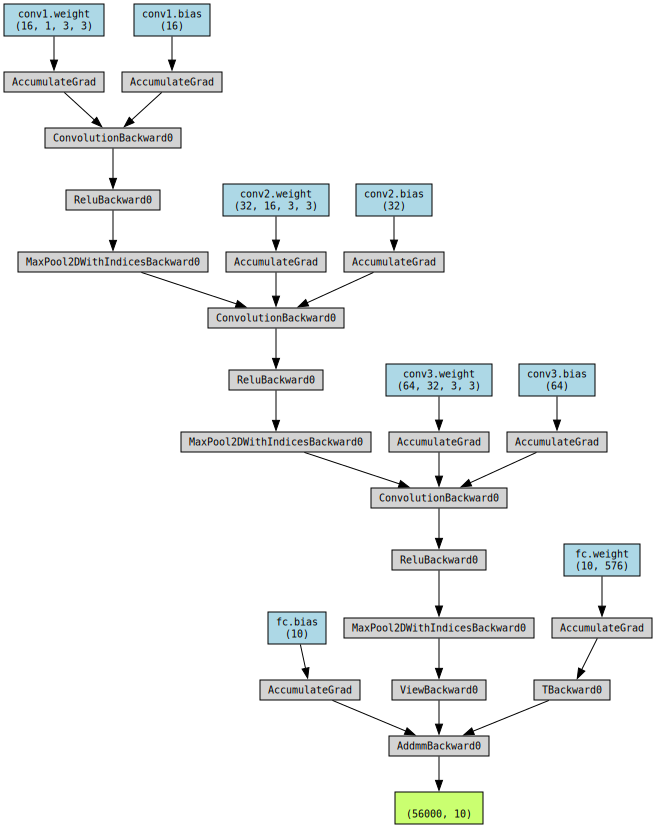

In [28]:
from torchviz import make_dot

#x=torch.randn(1,3,32,32).to(DEVICE)
#y=model(x)

make_dot(model(X_train),params=dict(model.named_parameters()))

In [42]:
from tqdm import tqdm # 프로그레스 바, tqdm 설치 후 갖고옴
import sys

def train(epoch):
    model.train()
    pbar = tqdm(total=len(train_loader)) # 전체 길이 지정해주기+새걸로 만들어주기! 
    for batch_idx, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        pbar.update(1) # 프로그레스 바 업데이트
        sys.stdout.flush()  # 출력 버퍼 비우기
        pbar.set_description(f'Train Epoch: {epoch}, Loss: {loss.item():.6f}')
    pbar.close() #종료

In [43]:
import torchmetrics

def evaluate(model, test_loader):
    model.eval() # 평가모드 "ON"
    test_loss = 0
    accuracy_metric = torchmetrics.Accuracy()

    with torch.no_grad():
        for image, label in test_loader:         
            output = model(image)
            test_loss += criterion(output, label).item() # 로스 누적 계싼
            accuracy_metric.update(output, label)  # 정확도 업데이트
            
    test_loss /= len(test_loader.dataset) # 평균화시킴
    test_accuracy = accuracy_metric.compute()  # 계산방법, 문서 참고해서 했는데 배운거랑 다르다;;
    return test_loss, test_accuracy

In [44]:
for epoch in range(1, 10):
    
    train(epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")

Train Epoch: 1, Loss: 0.000002: 100%|██████████| 1750/1750 [00:15<00:00, 113.17it/s]



[EPOCH: 1], 	Test Loss: 0.0018, 	Test Accuracy: 99.00 % 



Train Epoch: 2, Loss: 0.000012: 100%|██████████| 1750/1750 [00:15<00:00, 114.65it/s]



[EPOCH: 2], 	Test Loss: 0.0023, 	Test Accuracy: 98.80 % 



Train Epoch: 3, Loss: 0.001051: 100%|██████████| 1750/1750 [00:15<00:00, 115.32it/s]



[EPOCH: 3], 	Test Loss: 0.0021, 	Test Accuracy: 98.87 % 



Train Epoch: 4, Loss: 0.000001: 100%|██████████| 1750/1750 [00:15<00:00, 111.32it/s]



[EPOCH: 4], 	Test Loss: 0.0018, 	Test Accuracy: 99.01 % 



Train Epoch: 5, Loss: 0.000000: 100%|██████████| 1750/1750 [00:17<00:00, 101.30it/s]



[EPOCH: 5], 	Test Loss: 0.0019, 	Test Accuracy: 98.96 % 



Train Epoch: 6, Loss: 0.134279: 100%|██████████| 1750/1750 [00:15<00:00, 115.21it/s]



[EPOCH: 6], 	Test Loss: 0.0018, 	Test Accuracy: 98.97 % 



Train Epoch: 7, Loss: 0.000150: 100%|██████████| 1750/1750 [00:15<00:00, 113.44it/s]



[EPOCH: 7], 	Test Loss: 0.0018, 	Test Accuracy: 98.94 % 



Train Epoch: 8, Loss: 0.000002: 100%|██████████| 1750/1750 [00:16<00:00, 106.71it/s]



[EPOCH: 8], 	Test Loss: 0.0019, 	Test Accuracy: 98.99 % 



Train Epoch: 9, Loss: 0.001462: 100%|██████████| 1750/1750 [00:16<00:00, 107.14it/s]



[EPOCH: 9], 	Test Loss: 0.0018, 	Test Accuracy: 98.96 % 

